In [1]:
import pandas  as pd
import numpy   as np

import re
import random

import seaborn as sns
import matplotlib.pyplot as plt

from nltk import *
from sklearn import *

import gensim
from keras import models, layers, preprocessing as kprocessing

STOPWORDS_CORPUS = corpus.stopwords.words('english')
LEMMATIZATION    = WordNetLemmatizer()
STEMMING         = PorterStemmer()


2022-05-14 14:22:46.064225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 14:22:46.064286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)[['category','headline','short_description']]
df.groupby('category').count()

df['headline'] = df['headline'] + ' ' + df['short_description']


df = df.rename(columns = {'category':'Y', 'headline':'X'})


In [40]:
df.groupby('Y').count()

,X,short_description
Y,,
ARTS,1509,1509
ARTS & CULTURE,1339,1339
BLACK VOICES,4528,4528
BUSINESS,5937,5937
COLLEGE,1144,1144
COMEDY,5175,5175
CRIME,3405,3405
CULTURE & ARTS,1030,1030
DIVORCE,3426,3426


In [41]:
df.loc[df['Y'] == 'COMEDY', 'Y'] = 'ENTERTAINMENT'
df.loc[df['Y'] == 'ARTS', 'Y'] = 'ARTS & CULTURE'
df.loc[df['Y'] == 'STYLE', 'Y'] = 'STYLE & BEAUTY'
df.loc[df['Y'] == 'CULTURE & ARTS', 'Y'] = 'ARTS & CULTURE'
df.loc[df['Y'] == 'COLLEGE', 'Y'] = 'EDUCATION'
df.loc[df['Y'] == 'MONEY', 'Y'] = 'BUSINESS'
df.loc[df['Y'] == 'GREEN', 'Y'] = 'ENVIRONMENT'
df.loc[df['Y'] == 'TECH', 'Y'] = 'SCIENCE'

df = df[df['Y'] != 'QUEER VOICES']
df = df[df['Y'] != 'BLACK VOICES']
df = df[df['Y'] != 'WEDDINGS']
df = df[df['Y'] != 'THE WORLDPOST']
df = df[df['Y'] != 'PARENTS']
df = df[df['Y'] != 'IMPACT']
df = df[df['Y'] != 'WOMEN']
df = df[df['Y'] != 'WELLNESS']
df = df[df['Y'] != 'DIVORCE']
df = df[df['Y'] != 'FIFTY']
df = df[df['Y'] != 'PARENTING']
df = df[df['Y'] != 'WEIRD NEWS']
df = df[df['Y'] != 'WORLD NEWS']
df = df[df['Y'] != 'WORLDPOST']
df = df[df['Y'] != 'TASTE']
df = df[df['Y'] != 'LATINO VOICES']
df = df[df['Y'] != 'MEDIA']
df = df[df['Y'] != 'GOOD NEWS']



In [42]:
df.groupby('Y').count()

,X,short_description
Y,,
ARTS & CULTURE,3878,3878
BUSINESS,7644,7644
CRIME,3405,3405
EDUCATION,2148,2148
ENTERTAINMENT,21233,21233
ENVIRONMENT,3945,3945
FOOD & DRINK,6226,6226
HEALTHY LIVING,6694,6694
HOME & LIVING,4195,4195


In [43]:

df = df.groupby('Y').apply(lambda x: x.sample(min(len(x), 20000)))

In [44]:
def preprocess_string(text, lemmatizer = WordNetLemmatizer(), stemmer = PorterStemmer(), stopwords_corpus = corpus.stopwords.words('english')):
    text = str(text).lower().strip()
    text = re.sub(r'[^\w\s]', '', text).split()
    text = [word for word in text if word not in stopwords_corpus]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    return text

In [45]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/ciprian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ciprian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [46]:
df['X'] = df['X'].apply(lambda text: preprocess_string(text, LEMMATIZATION, STEMMING, STOPWORDS_CORPUS))

In [47]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df['X'], df['Y'], test_size=0.20)

In [48]:
word_weights = gensim.models.word2vec.Word2Vec(X_train, vector_size=350, min_count=1, sg=1).wv

In [49]:
word_weights.save_word2vec_format('word_weights.txt')

In [50]:
tokenizer = kprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
dic_vocabulary = tokenizer.word_index

In [51]:
#save tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [52]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

X_test  = kprocessing.sequence.pad_sequences(X_test,  maxlen=128, padding="post", truncating="post")
X_train = kprocessing.sequence.pad_sequences(X_train, maxlen=128, padding="post", truncating="post")


In [53]:
label_encoder = preprocessing.LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)

In [54]:
embeddings = np.zeros((len(dic_vocabulary) + 1, 350))
for word, i in dic_vocabulary.items():
    try:
        embeddings[i] = word_weights[word]
    except:
        pass

In [55]:
def embedding_layer(inputs, length, embeddings):
    return layers.Embedding(input_dim    = embeddings.shape[0],  
                            output_dim   = embeddings.shape[1], 
                            weights      = [embeddings],
                            input_length = length, 
                            trainable    = False)(inputs)

input = layers.Input(shape=(128,))

output_embedding = embedding_layer(input, 128, embeddings)

outuput_LSTM1 = layers.Bidirectional(layers.LSTM(units=128, dropout=0.2, return_sequences=True))(output_embedding)
outuput_LSTM2 = layers.Bidirectional(layers.LSTM(units=128, dropout=0.2))(outuput_LSTM1)
ouput_dense   = layers.Dense(64, activation='relu')(outuput_LSTM2)

output = layers.Dense(len(label_encoder.classes_), activation='softmax')(ouput_dense)

model = models.Model(input, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 350)          19117700  
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 256)         490496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 15)                975 

In [74]:
training = model.fit(x=X_train, y=Y_train, batch_size=256, 
                     epochs=1, shuffle=True, verbose=2, 
                     validation_split=0.2)

280/280 - 377s - loss: 0.5398 - accuracy: 0.8215 - val_loss: 0.7922 - val_accuracy: 0.7554 - 377s/epoch - 1s/step


In [75]:
Y_predicted_prob = model.predict(X_test)
Y_predicted = [label_encoder.classes_[np.argmax(pred)] for pred in Y_predicted_prob]st drive: The 2022 Ford F-150 Lightning is a pped with features not found on the other models.

General accuracy: 0.76
General auc: 0.97
Detail:
                precision    recall  f1-score   support

ARTS & CULTURE       0.55      0.64      0.59       758
      BUSINESS       0.62      0.66      0.64      1540
         CRIME       0.78      0.62      0.69       692
     EDUCATION       0.65      0.49      0.55       402
 ENTERTAINMENT       0.82      0.76      0.79      4043
   ENVIRONMENT       0.66      0.63      0.64       791
  FOOD & DRINK       0.77      0.90      0.83      1249
HEALTHY LIVING       0.60      0.70      0.65      1340
 HOME & LIVING       0.84      0.74      0.79       869
      POLITICS       0.80      0.85      0.83      4021
      RELIGION       0.70      0.67      0.68       508
       SCIENCE       0.59      0.56      0.58       864
        SPORTS       0.74      0.79      0.76       994
STYLE & BEAUTY       0.88      0.83      0.85      2371
        TRAVEL       0.83      0.77      0.79      1883

      accuracy                           0.76     223

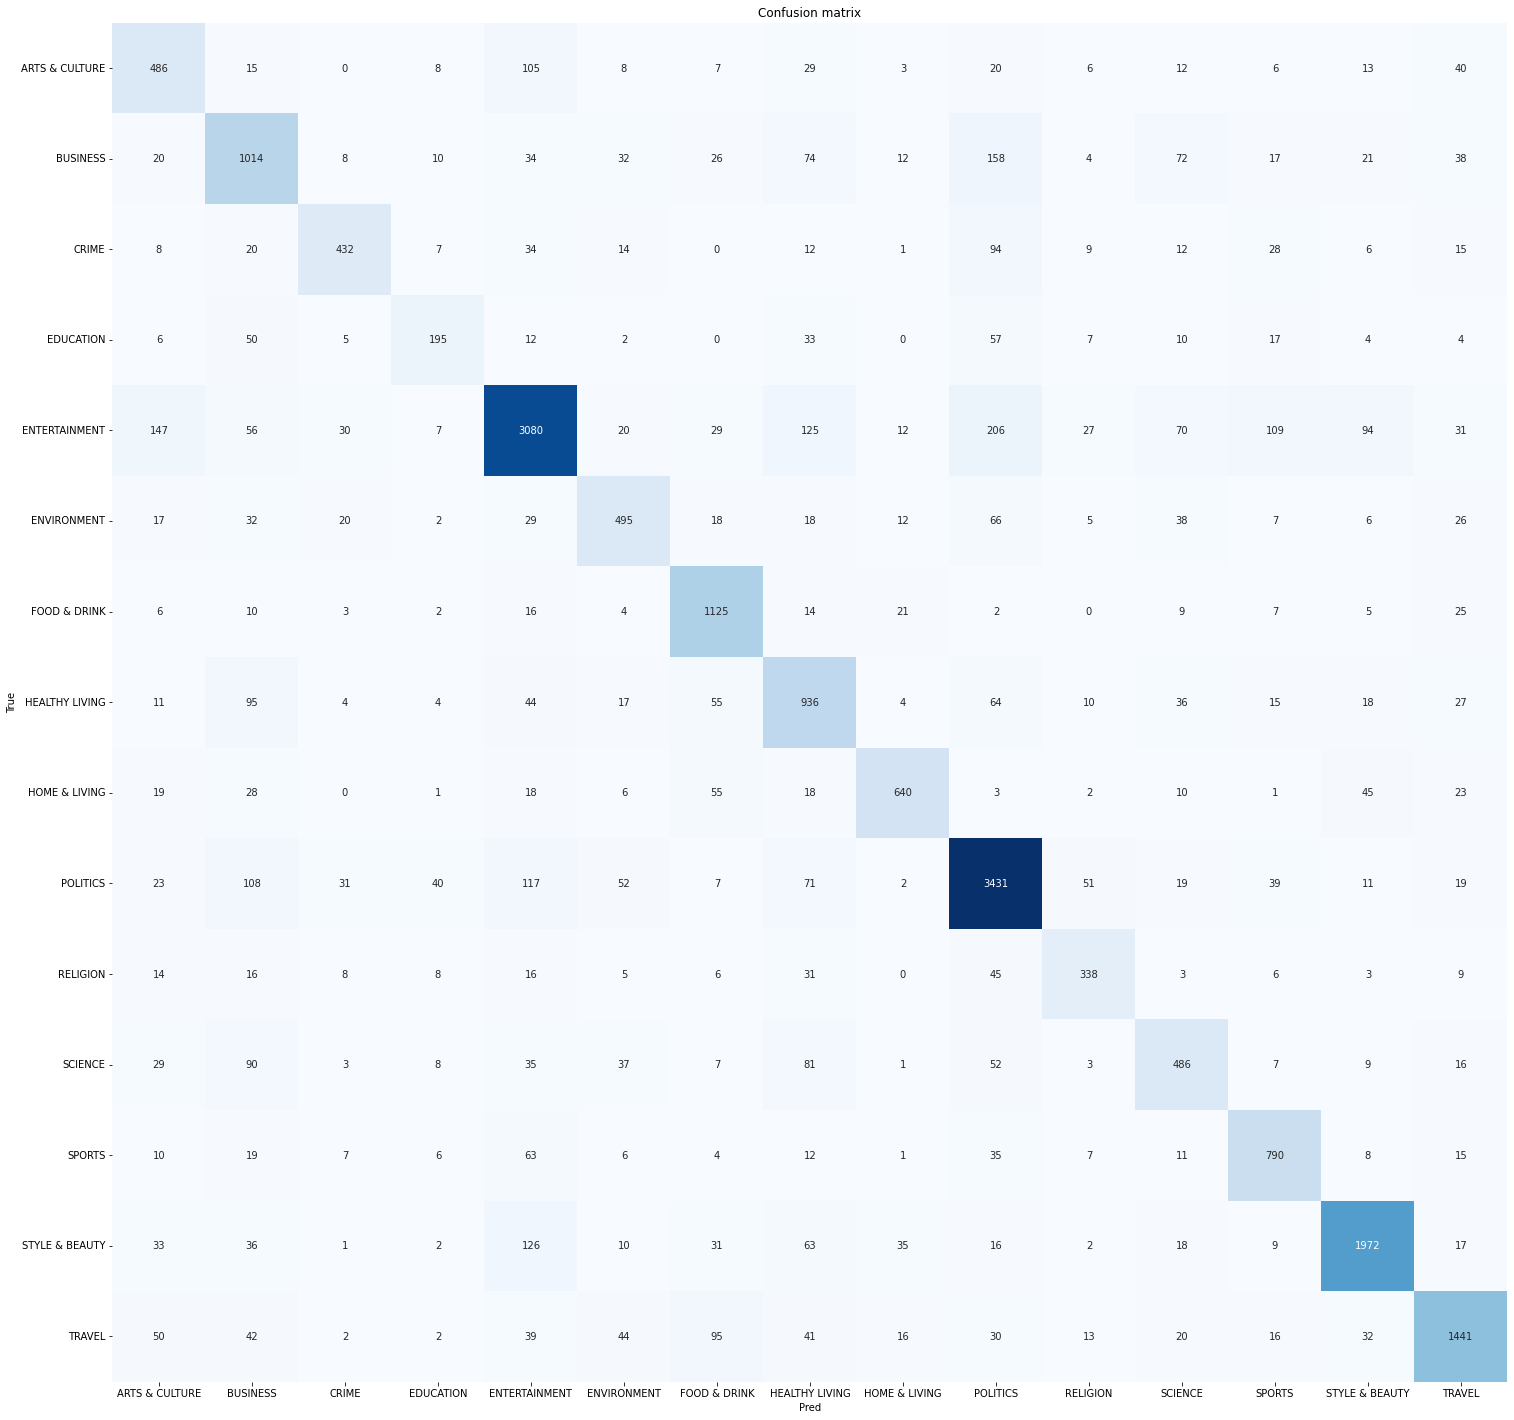

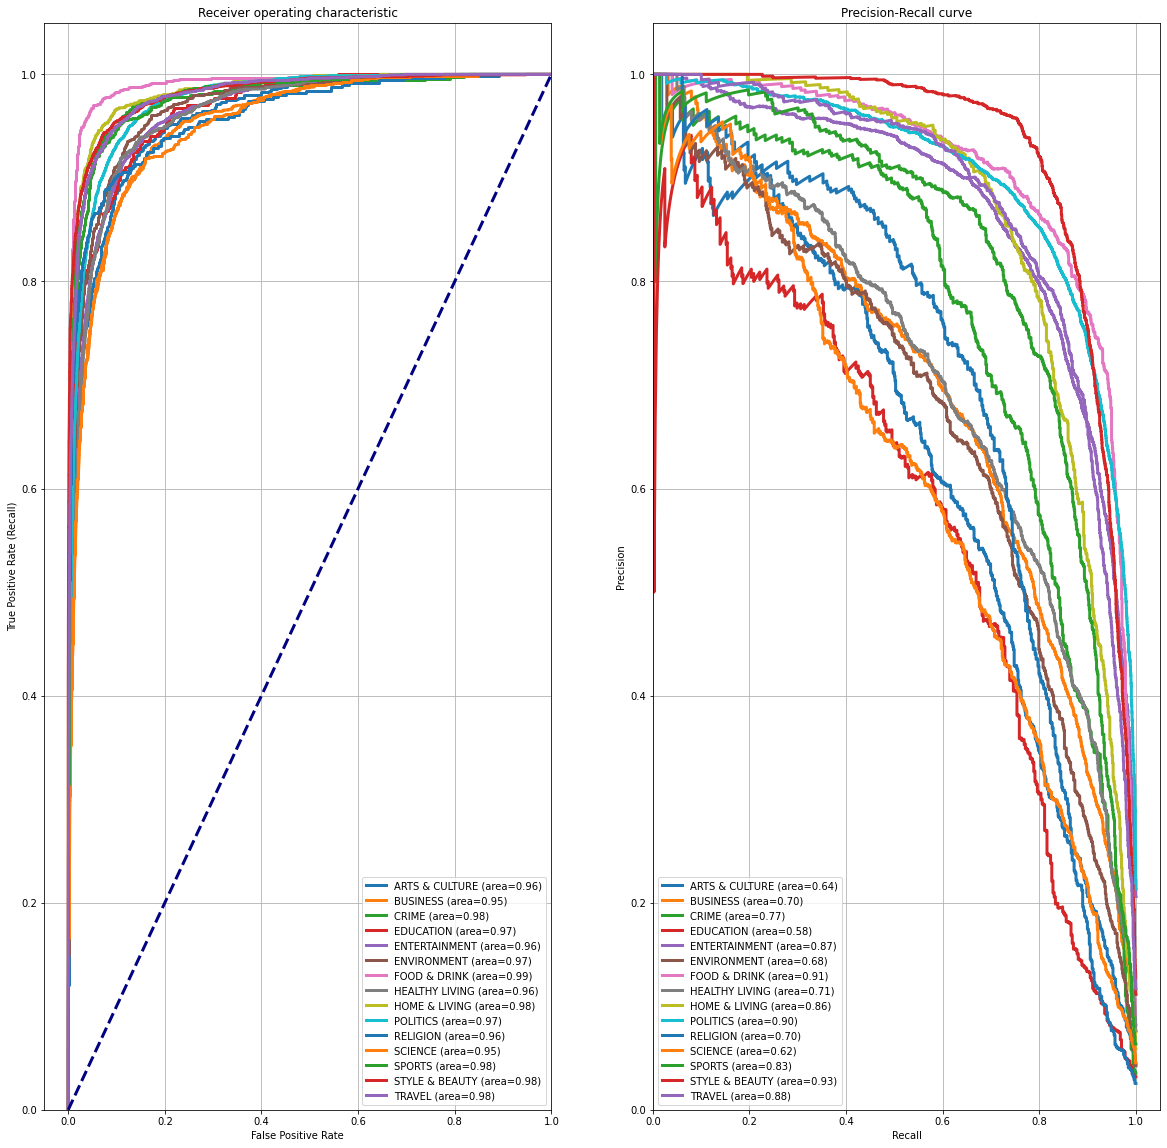

In [77]:
classes = np.unique(Y_test)
Y_test_OHE = pd.get_dummies(Y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(Y_test, Y_predicted)
auc = metrics.roc_auc_score(Y_test, Y_predicted_prob, 
                            multi_class="ovr")

print("General accuracy:",  round(accuracy,2))
print("General auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(Y_test, Y_predicted))
    
## CONFUSSION MATRIX
cm = metrics.confusion_matrix(Y_test, Y_predicted)
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 20))

##  ROC
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(Y_test_OHE[:,i], Y_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3,label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')

ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")

ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## PRECISION RECALL CURVE
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(Y_test_OHE[:,i], Y_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3,label='{0} (area={1:0.2f})'.format(classes[i],metrics.auc(recall, precision)))
    
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [72]:
#save model
model.save('model2.h5')

In [73]:
np.unique(Y_test)

array(['ARTS & CULTURE', 'BUSINESS', 'CRIME', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FOOD & DRINK', 'HEALTHY LIVING',
       'HOME & LIVING', 'POLITICS', 'RELIGION', 'SCIENCE', 'SPORTS',
       'STYLE & BEAUTY', 'TRAVEL'], dtype=object)